This is a minimal example showing how to run the inference of UResNet+PPN network.

Summary:

1. [Quickstart with `inference_simple` function](#1.-Quickstart-with-inference_simple-function)
    1. [Opening our dataset](#1.1.-Opening-our-dataset)
    2. [Running the inference](#1.2.-Running-the-inference)
    3. [Output of the inference](#1.3.-Output-of-the-inference)
2. [Using cropping](#2.-Using-cropping)
3. [Using `inference` function as a black box](#3.-Using-inference-function-as-a-black-box)

We need to import a few things to begin with.

In [1]:
import sys
sys.path.append('../..')
import os
import tensorflow as tf
import numpy as np

from faster_particles.config import PPNConfig
from faster_particles.ppn import PPN
from faster_particles.base_net.uresnet import UResNet
from faster_particles.demo_ppn import inference, inference_simple, get_data, cluster
from faster_particles.display_utils import display_blob, display_predictions, \
                                            display_blob_rois, display_labels, draw_slicing
from faster_particles.cropping import cropping_algorithms

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.14/04


In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


Next we define the configuration. If you do not plan to use the data generators from `faster_particles` package, you can leave out `DATA` and `TEST_DATA` fields. There are many more parameters, see `config.py` for the details and the default values. This is a minimal working configuration.

In [3]:
cfgargs = {
    'DISPLAY_DIR': 'container_demo',  # Folder where event displays will be stored
    'BASE_NET': 'uresnet',  # We want to use UResNet encoding layers for PPN
    'NET': 'full',  # We will be running inference for both UResNet and PPN
    'MAX_STEPS': 10,  # How many images we should run over
    'DATA_3D': True,  # 3D data
    'WEIGHTS_FILE_BASE': "/data/train_uresnet3d2/model-62000.ckpt",  # UResNet weights
    'WEIGHTS_FILE_PPN': "/data/train_ppn34/model-100000.ckpt",  # PPN weights
    'DATA': "/data/dlprod_ppn_v08_p02_filtered/train_p02.root",  # Train dataset (LArCV format)
    'TEST_DATA': "/data/dlprod_ppn_v08_p02_filtered/test_p02.root",  # Test dataset (LArCV format)
    'IMAGE_SIZE': 192,  # Size of 1 side of the image (in pixels)
    'PPN1_INDEX': 1,  # Index of UResNet layer that should be used for PPN2 stage
    'PPN2_INDEX': 3  # Index of UResNet layer that should be used for PPN1 stage
}
cfg = PPNConfig(**cfgargs)

# 1. Quickstart with `inference_simple` function
We ignore cropping for now and focus on the inference process.

## 1.1. Opening our dataset
The data generators take files in LArCV, HDF5 or CSV formats (see source code for more details). Here we read entries from LArCV files. The generator returns a dictionary with the event voxels, labels, ground truth pixels for shower/track edge points, etc. Each entry of the dictionary is a Numpy array.

In [4]:
# Retrieve data and keep only test dataset
_, data = get_data(cfg)

blobs = []
for i in range(cfg.MAX_STEPS):
    blob = data.forward()
    blobs.append([blob])

 setting verbosity 3
 setting verbosity 3


In [5]:
for key in blobs[0][0]:
    try:
        print key, blobs[0][0][key].shape
    except AttributeError:
        print "=", blobs[0][0][key]

voxels (1446, 3)
labels (1, 192, 192, 192)
data (1, 192, 192, 192, 1)
gt_pixels (5, 4)
entries = [6961L]


Instead of using a data generator from the package, you could also generate your own data as Numpy arrays. You only need to wrap it in a dictionary the following way:

In [6]:
my_blobs = []
for i in range(cfg.MAX_STEPS):
    blob = {}
    my_data = np.arange(cfg.IMAGE_SIZE**3).reshape((1, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE, 1))
    blob['data'] = my_data
    # only used at training time but still need to fill in these fields
    blob['labels'] = my_data[..., 0]  
    blob['gt_pixels'] = np.zeros((1, 4))
    my_blobs.append([blob])

Notice that for the inference you are required to provide `labels` and `gt_pixels` values even if they are dummy.

For the sake of this notebook we will stick with our LArCV dataset. We can take a look at the first 3 events and their labels:

0


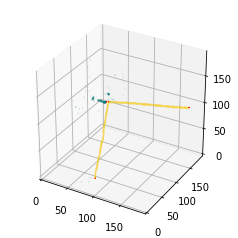

1


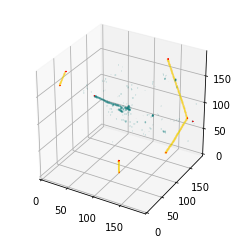

2


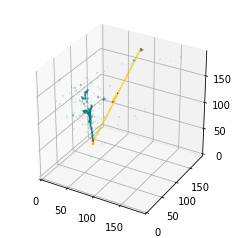

In [7]:
for i in range(min(3, cfg.MAX_STEPS)):
    print i
    # Uncomment this line to display the barebone event
    # display_blob(blobs[i][0], cfg, projection='3d')
    display_labels(blobs[i][0], cfg, projection='3d')

## 1.2. Running the inference
Now we can run the inference. The `inference_simple` function handles the technical details, it only needs the configuration file, dataset (`blobs`), network and number of iterations.

In [8]:
inference_base, inference_ppn = [], []
weights_file_ppn = cfg.WEIGHTS_FILE_PPN

tf.reset_default_graph()

# Run UResNet inference
cfg.WEIGHTS_FILE_PPN = None
net_base = UResNet(cfg=cfg)
inference_base = inference_simple(cfg, blobs, net_base, num_test=cfg.MAX_STEPS)

tf.reset_default_graph()

# Run PPN inference
cfg.WEIGHTS_FILE_PPN = weights_file_ppn
net_ppn = PPN(cfg=cfg, base_net=UResNet)
inference_ppn = inference_simple(cfg, blobs, net_ppn, num_test=cfg.MAX_STEPS)

Restoring checkpoint file...
Restoring /data/train_uresnet3d2/model-62000.ckpt...
- ignoring 0/232 variables
INFO:tensorflow:Restoring parameters from /data/train_uresnet3d2/model-62000.ckpt
Done.
Average duration of inference = 1.229385 s
N2 = 96 ; N3 = 24 ; dim1 = 2 ; dim2 = 4
Restoring checkpoint file...
Restoring /data/train_ppn34/model-100000.ckpt...
- ignoring 0/128 variables
INFO:tensorflow:Restoring parameters from /data/train_ppn34/model-100000.ckpt
Done.
Average duration of inference = 0.167298 s


For further processing let's merge the results from UResNet and PPN:

In [9]:
final_results = []
for i in range(cfg.MAX_STEPS):
    results = {}
    results.update(inference_base[i][0])
    results.update(inference_ppn[i][0])
    final_results.append(results)

## 1.3. Output of the inference
Let's have a look at the output dictionary:

In [10]:
for key in final_results[0]:
    print key, final_results[0][key].shape

im_scores (3,)
softmax (1, 192, 192, 192, 3)
im_proposals (3, 3)
scores (1, 192, 192, 192)
rois (192, 3)
predictions (1, 192, 192, 192)
im_labels (192,)


* `im_proposals` contains the coordinates of points proposed by PPN.
* `im_scores` is the score associated to each point proposed by PPN.
* `rois` contains the coordinates of ROIs proposed by the first stage of PPN.
* `predictions` is the segmentation map output by UResNet.
* `softmax` is the associated softmax from UResNet last layer.
* `scores` is the score of each voxel from UResNet

Let's display some of these arrays, we can start with `predictions` from UResNet combined with `im_proposals` from PPN.

0 / 10


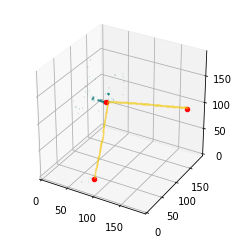

1 / 10


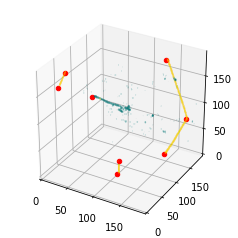

2 / 10


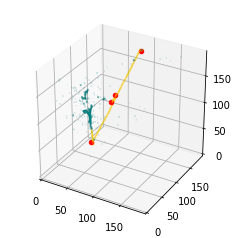

In [11]:
for i in range(min(3, cfg.MAX_STEPS)):
    print "%d / %d" % (i, cfg.MAX_STEPS)
    display_predictions(
        blobs[i][0],
        cfg,
        final_results[i]['predictions'],
        im_proposals=final_results[i]['im_proposals'],
        im_scores=final_results[i]['im_scores'],
        im_labels=final_results[i]['im_labels'],
        projection='3d'
    )

Now we can also display the ROIs of PPN1 stage:

0 / 10


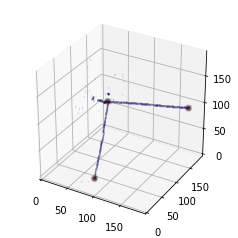

1 / 10


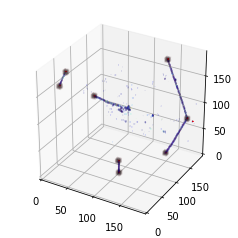

2 / 10


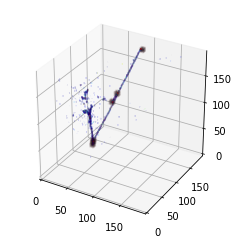

In [12]:
for i in range(min(3, cfg.MAX_STEPS)):
    print "%d / %d" % (i, cfg.MAX_STEPS)
    display_blob_rois(blobs[i][0], cfg, final_results[i]['rois'], net_ppn.dim1, net_ppn.dim2, projection='3d')

We can do some barebone clustering afterwards using DBSCAN:

Clusters:  [-1  0  1  2  3  4  5]


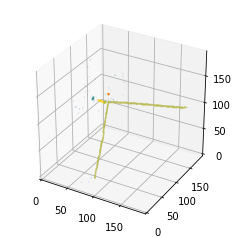

Clusters:  [-1  0  1  2  3  4  5  6  7  8  9]


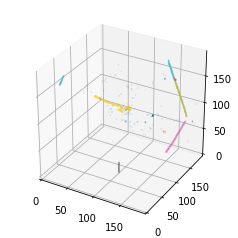

Clusters:  [-1  0  1  2  3  4  5  6  7  8  9 10]


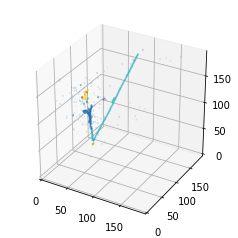

In [13]:
for i in range(min(3, cfg.MAX_STEPS)):
    cluster(cfg, blobs[i][0], final_results[i], i)

# 2. Using cropping
If our data is too big to fit the GPU memory, we will have to crop it. The script follows the same logic as in 1., except we have to add a few lines for the cropping algorithm. We use the default algorithm which is probabilistic (see the source `cropping/probabilistic.py` for details about it).

## 2.1. Crop the dataset
First we need to change the configuration, we add 3 parameters to account for the `SLICE_SIZE` (size of a crop, constant for now), `CORE_SIZE` (central region of the crop, used to try and reach a reasonable overlap between boxes), and `ENABLE_CROP` to activate cropping:

In [14]:
cfgargs = {
    'DISPLAY_DIR': 'container_demo',  # Folder where event displays will be stored
    'BASE_NET': 'uresnet',  # We want to use UResNet encoding layers for PPN
    'NET': 'full',  # We will be running inference for both UResNet and PPN
    'MAX_STEPS': 10,  # How many images we should run over
    'DATA_3D': True,  # 3D data
    'WEIGHTS_FILE_BASE': "/data/train_uresnet3d2/model-62000.ckpt",  # UResNet weights
    'WEIGHTS_FILE_PPN': "/data/train_ppn34/model-100000.ckpt",  # PPN weights
    'DATA': "/data/dlprod_ppn_v08_p02_filtered/train_p02.root",  # Train dataset (LArCV format)
    'TEST_DATA': "/data/dlprod_ppn_v08_p02_filtered/test_p02.root",  # Test dataset (LArCV format)
    'IMAGE_SIZE': 192,  # Size of 1 side of the image (in pixels)
    'PPN1_INDEX': 1,  # Index of UResNet layer that should be used for PPN2 stage
    'PPN2_INDEX': 3,  # Index of UResNet layer that should be used for PPN1 stage
    # ---- Here is what we add to enable cropping ----
    'SLIZE_SIZE': 64,
    'CORE_SIZE': 32,
    'ENABLE_CROP': True,
}
cfg = PPNConfig(**cfgargs)

Then we load the cropping algorithm:

In [15]:
crop_algorithm = cropping_algorithms[cfg.CROP_ALGO](cfg)

Now when we create our dataset we call the cropping algorithm on each event:

In [16]:
blobs = []
original_blobs = []
patch_centers_list, patch_sizes_list = [], []

for i in range(cfg.MAX_STEPS):
    blob = data.forward()
    original_blobs.append(blob)
    batch_blobs, patch_centers, patch_sizes = crop_algorithm.process(blob)
    patch_centers_list.append(patch_centers)
    patch_sizes_list.append(patch_sizes)
    blobs.append(batch_blobs)

`patch_centers_list` holds the list of coordinates of all the crop centers. `patch_sizes_list` holds the list of associated sizes for each crop.

In [17]:
print patch_centers_list[0].shape
print patch_sizes_list[0].shape

(35, 3)
(35,)


We can visualize with `draw_slicing` what the cropping algorithm did. It will also show us how many crops a voxel belongs to, i.e. a measure of overlap between crop boxes.

0
Crops


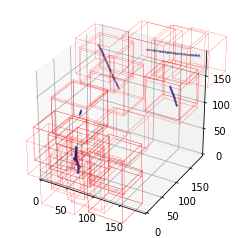

Number of crops to which a voxel belongs (overlap)


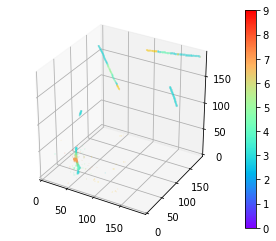

In [18]:
for i in range(min(1, cfg.MAX_STEPS)):
    print i
    draw_slicing(
        original_blobs[i],
        cfg,
        patch_centers_list[i],
        patch_sizes_list[i]
    )

## 2.2. Running the inference

The inference calls in themselves are exactly the same as above. Dealing with crops is done in the `inference_simple` function. 

In [19]:
inference_base, inference_ppn = [], []
weights_file_ppn = cfg.WEIGHTS_FILE_PPN

tf.reset_default_graph()

# Run UResNet inference
cfg.WEIGHTS_FILE_PPN = None
net_base = UResNet(cfg=cfg)
inference_base = inference_simple(cfg, blobs, net_base, num_test=cfg.MAX_STEPS)

tf.reset_default_graph()

# Run PPN inference
cfg.WEIGHTS_FILE_PPN = weights_file_ppn
net_ppn = PPN(cfg=cfg, base_net=UResNet)
inference_ppn = inference_simple(cfg, blobs, net_ppn, num_test=cfg.MAX_STEPS)

Restoring checkpoint file...
Restoring /data/train_uresnet3d2/model-62000.ckpt...
- ignoring 0/232 variables
INFO:tensorflow:Restoring parameters from /data/train_uresnet3d2/model-62000.ckpt
Done.
Average duration of inference = 0.043404 s
N2 = 32 ; N3 = 8 ; dim1 = 2 ; dim2 = 4
Restoring checkpoint file...
Restoring /data/train_ppn34/model-100000.ckpt...
- ignoring 0/128 variables
INFO:tensorflow:Restoring parameters from /data/train_ppn34/model-100000.ckpt
Done.
Average duration of inference = 0.011902 s


When we merge the results from PPN and UResNet we will need an additional for loop:

In [20]:
final_crop_results = []
for i in range(cfg.MAX_STEPS):
    batch_results = []
    for j in range(len(blobs[i])):
        results = {}
        results.update(inference_base[i][j])
        results.update(inference_ppn[i][j])
        batch_results.append(results)
    final_crop_results.append(batch_results)

## 2.3. Reconciling results

We can reconcile (merge) the results using the cropping algorithm:

In [21]:
final_reconciled_results = []
cfg.dim1 = net_ppn.dim1
cfg.dim2 = net_ppn.dim2

for i in range(cfg.MAX_STEPS):
    batch_results = final_crop_results[i]
    final_result = crop_algorithm.reconcile(batch_results, patch_centers_list[i], patch_sizes_list[i])
    final_reconciled_results.append(final_result)

And just as before we can display them with `display_predictions`:

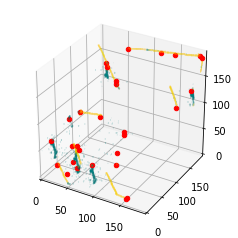

In [22]:
for i in range(min(1, cfg.MAX_STEPS)):
    display_predictions(
        original_blobs[i],
        cfg,
        final_reconciled_results[i]['predictions'],
        im_proposals=final_reconciled_results[i]['im_proposals'],
        im_scores=final_reconciled_results[i]['im_scores'],
        im_labels=final_reconciled_results[i]['im_labels'],
        projection='3d'        
    )

# 3. Using `inference` function as a black box
If we use data generators from the package, we can also just use the `inference` function which takes care of many things, among which event displays, metrics, etc. We can retrieve the data that was generated (same as before, each blob is a dictionary of Numpy arrays) and the results (dictionary of Numpy arrays).

In [ ]:
blobs, final_results = inference(cfg)